# Prediction of protein isoforms using semi-supervised learning

## PCA

In [ ]:
###############################################################
# IMPORT PACKAGES
###############################################################

import pandas as pd
import numpy as np
from scipy.linalg import svd
import h5py

###############################################################
# IMPORT DATA
###############################################################

f_gtex_gene = h5py.File('/dtu-compute/datasets/iso_02456/hdf5/gtex_gene_expression_norm_transposed.hdf5', mode='r')
X = f_gtex_gene['expressions'][:]

row_header = list(f_gtex_gene['row_names'][:])
row_header = [row.decode('utf-8') for row in row_header]
row_header = np.array(row_header)
row_header = row_header.reshape(-1,1)

col_header = np.hstack((np.array(["id"]), np.arange(2000)))

###############################################################
# PCA
###############################################################

N = X.shape[0]

Y = X - np.ones((N, 1))*X.mean(0)
Y = Y*(1/np.std(Y,0))

U,S,Vh = svd(X,full_matrices=False)
V = Vh.T    

Z = Y @ V
Z = Z[:,:2000]
print(f"Z.shape: {Z.shape}")

###############################################################
# REARRANGE DATA WITH HEADERS
###############################################################

Z = np.hstack((row_header, Z))

print(f"Z.shape: {Z.shape}")

###############################################################
# SAVE DATA
###############################################################

Z_df = pd.DataFrame(Z, columns = col_header)
Z_df.to_csv('PCA.tsv.gz', sep='\t', index=False, compression="gzip")

###############################################################
# VARIANCE
###############################################################

rho = (S*S) / (S*S).sum()

rho_df = pd.DataFrame(rho)
rho_df.to_csv('rho.tsv.gz', sep='\t', index=False, compression="gzip")

## VAE

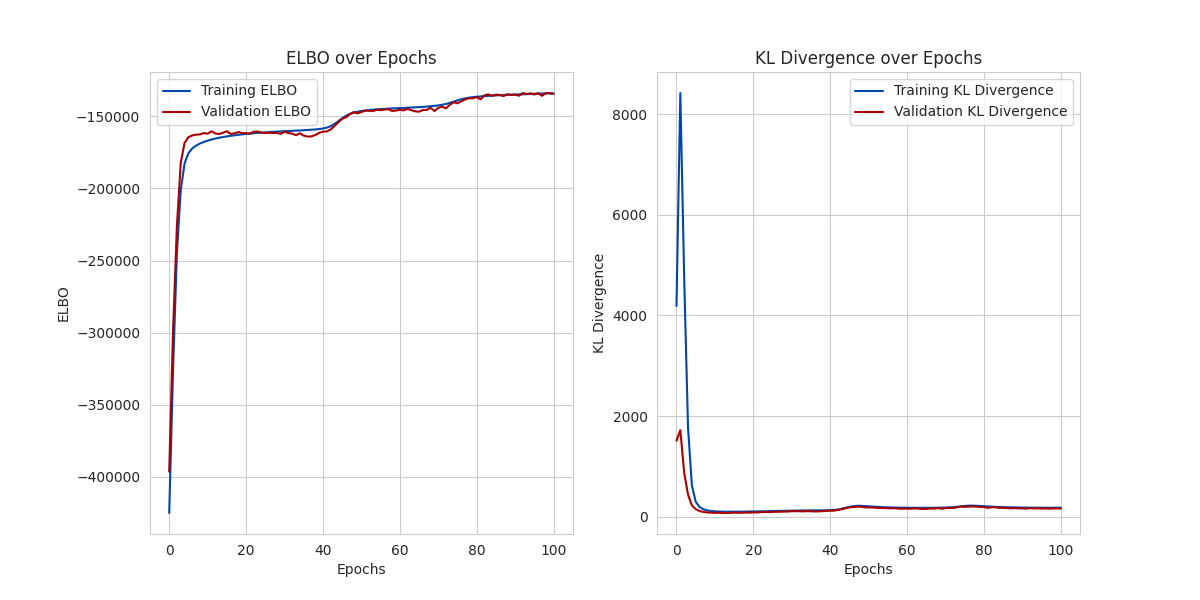

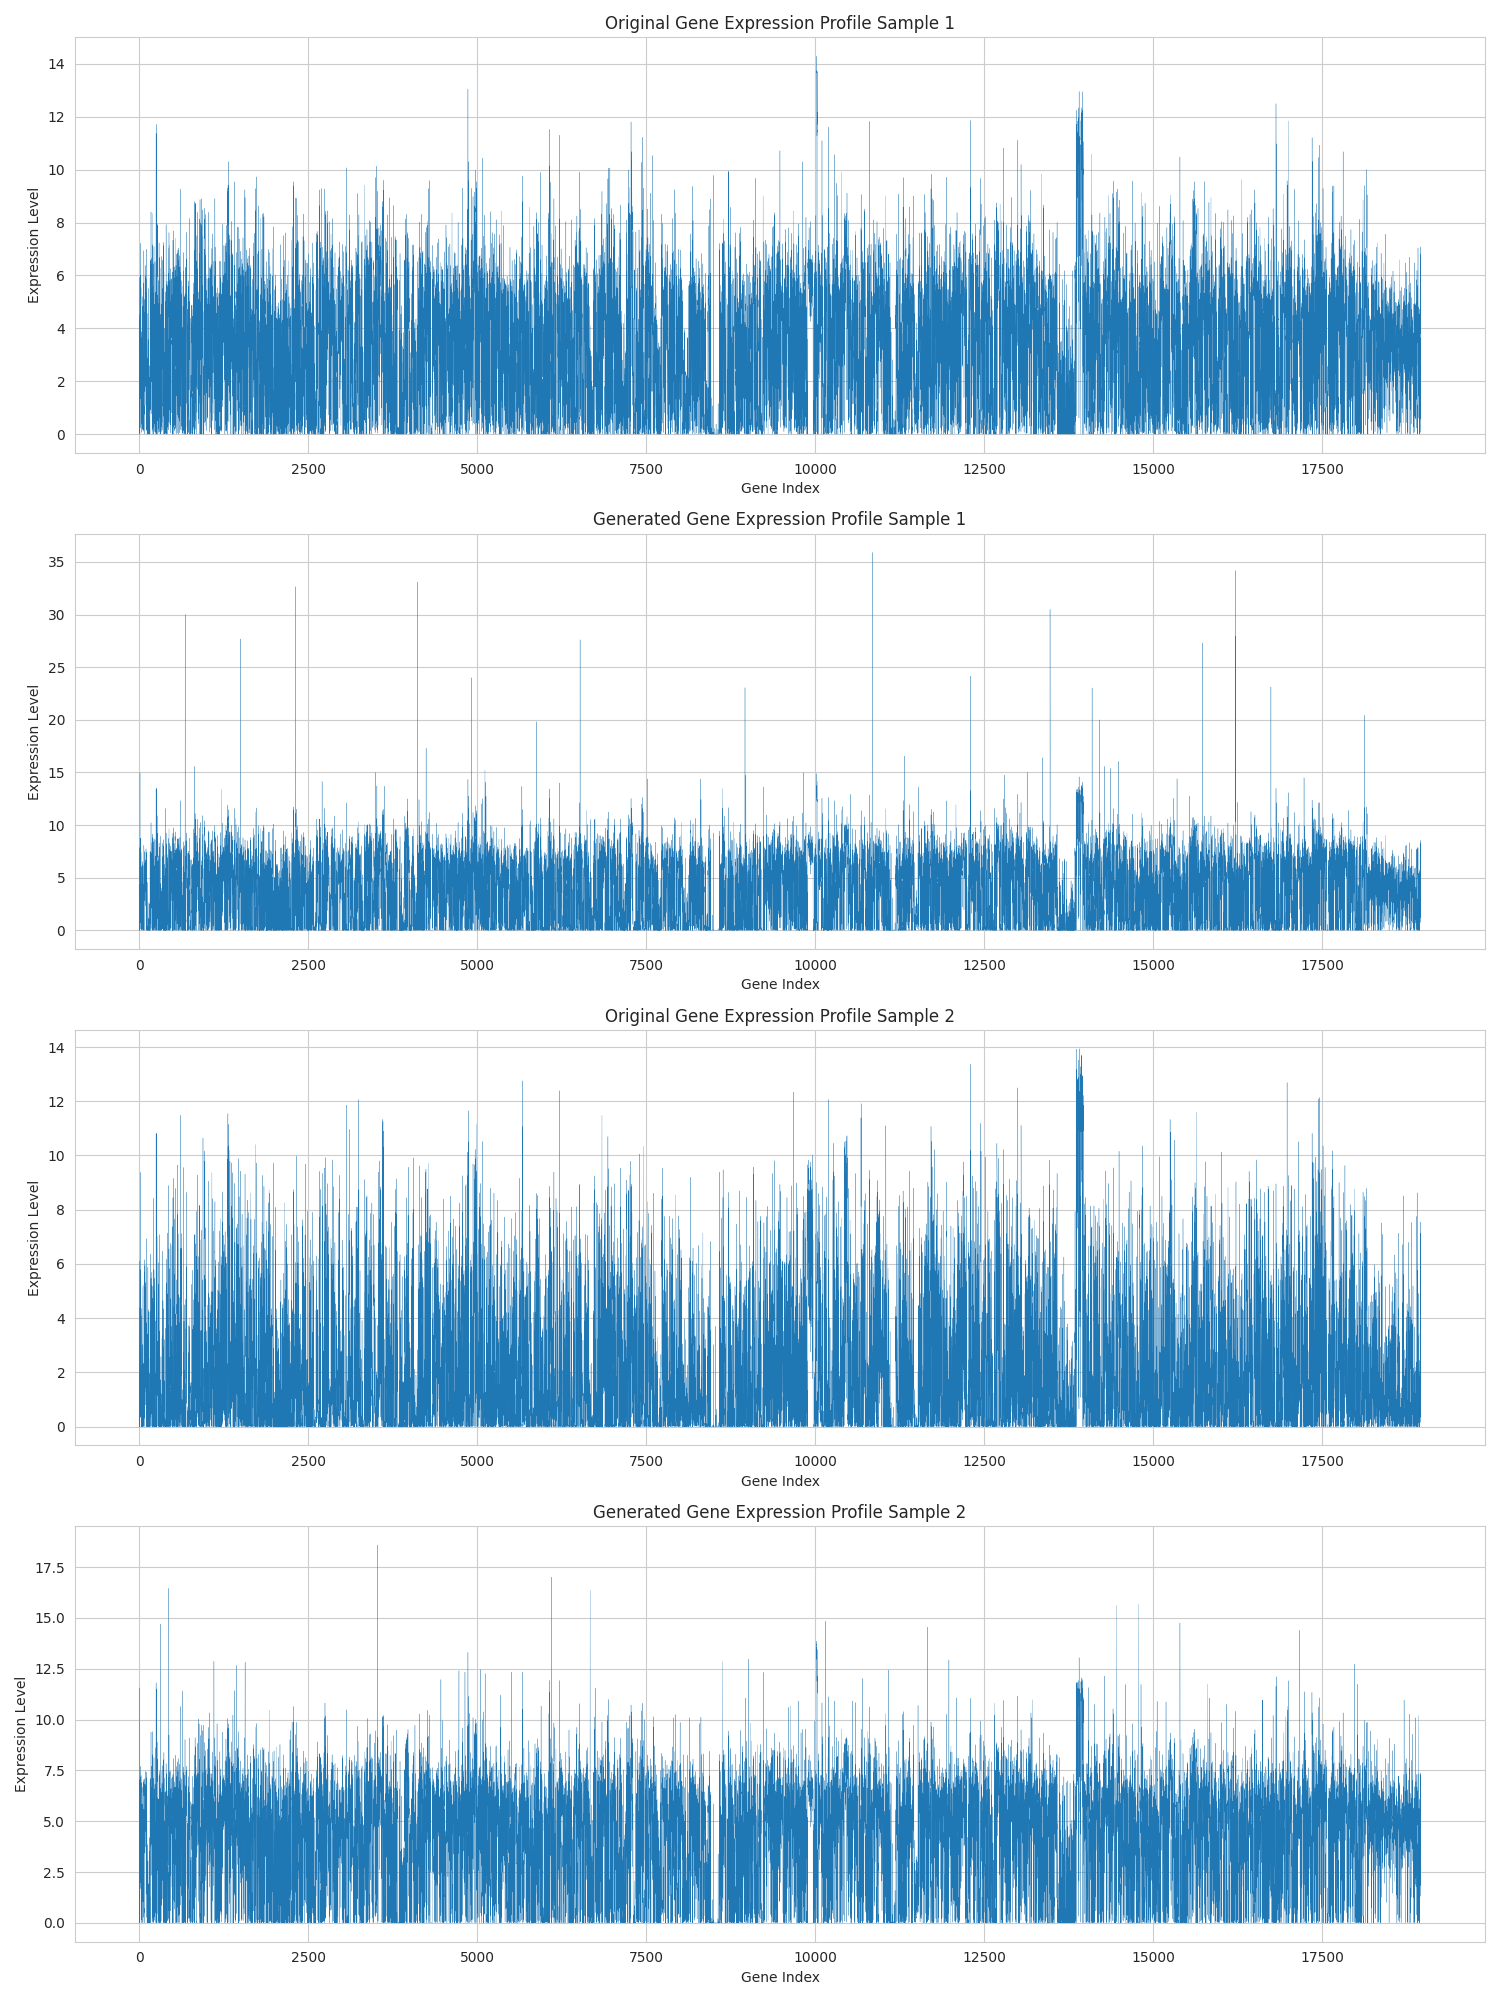

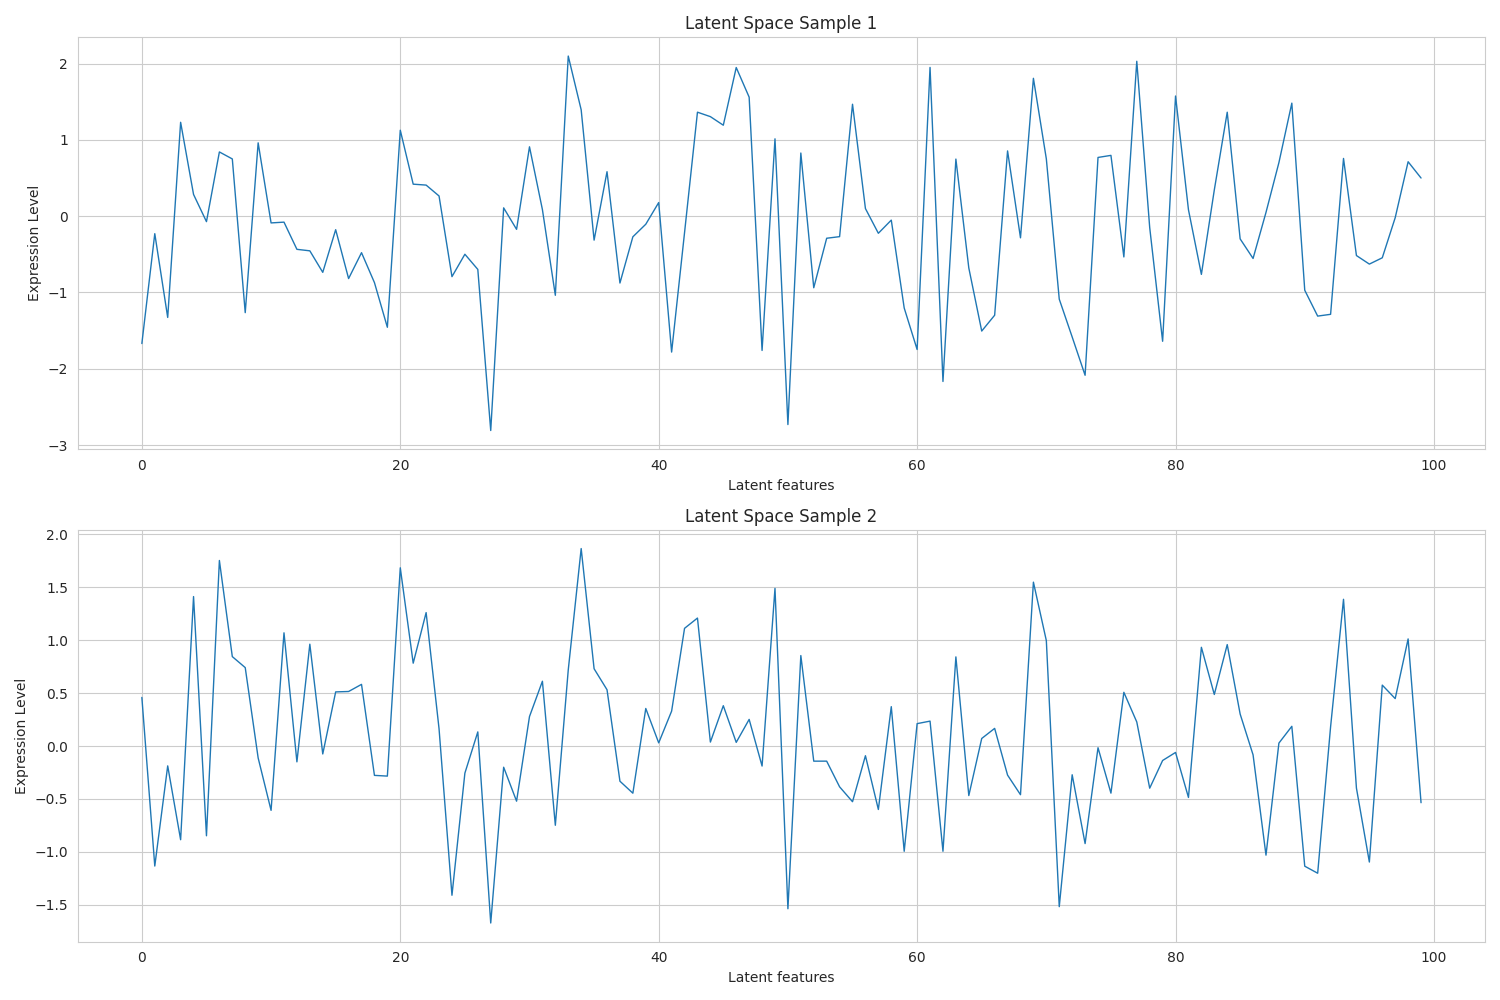

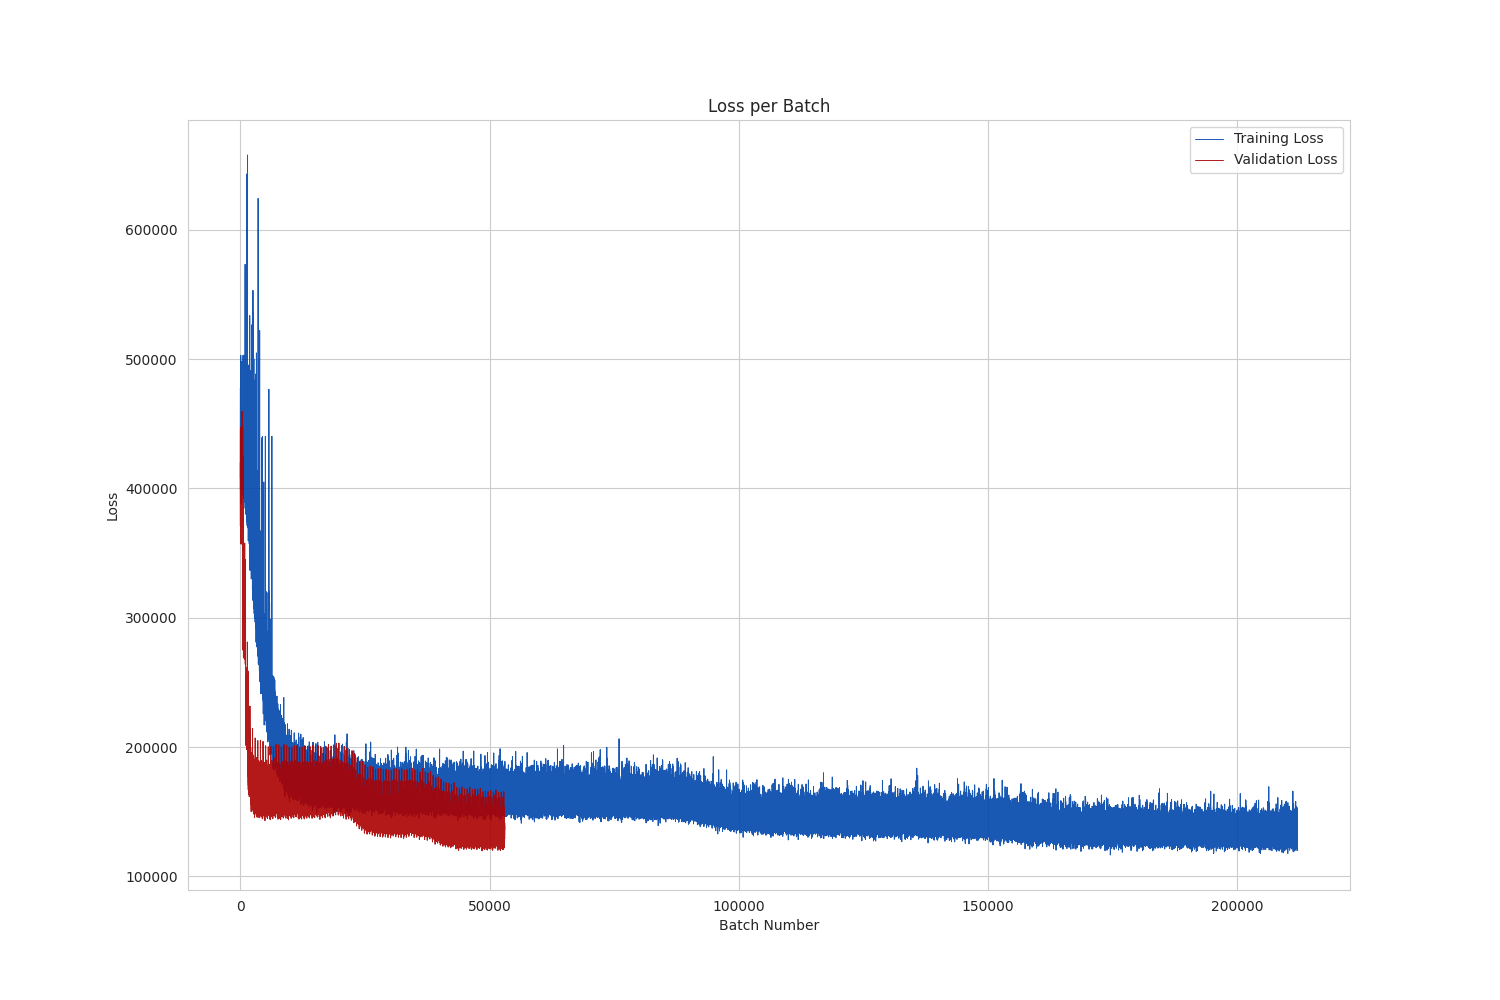

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[2]:


from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")
import requests

import math
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution, LogNormal


from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce
from torch.distributions.bernoulli import Bernoulli

import IsoDatasets
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from collections import defaultdict




import gzip
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# ## Helper functions

# In[3]:
# Define your color dictionary

color_dict = {
    'red': '#ab0000',   # Dark red
    'blue': '#0047ab'   # Dark blue
}

def load_data_chunk(filename, chunk_size=1000):
    """ Load a chunk of data from a gzipped TSV file. """
    return pd.read_csv(filename, sep='\t', compression='gzip', chunksize=chunk_size)

def separate_ids_and_data(data):
    ids = data.iloc[:, 0]
    data = data.iloc[:, 1:]
    return ids, data

def create_data_loaders(data_dir, batch_size, train_percent=0.8, load_in_mem=False):
    full_dataset = IsoDatasets.Archs4GeneExpressionDataset(data_dir, load_in_mem)
    train_size = int(train_percent * len(full_dataset))
    test_size = len(full_dataset) - train_size

    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader

def plot_line(tensor, axs, title, xlabel, ylabel, line_width=1.0,):
    # Check if the input is a PyTorch tensor
    if isinstance(tensor, torch.Tensor):
        # Check if the tensor is on a CUDA device and move it to CPU if necessary
        if tensor.is_cuda:
            tensor = tensor.cpu()

        # Convert the Torch tensor to a NumPy array
        numeric_array = tensor.detach().numpy()
    else:
        # If it's not a tensor, assume it's already a NumPy array
        numeric_array = tensor

    # Plotting code remains the same
    axs.plot(numeric_array, linewidth=line_width)
    axs.set_title(title)
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)

def plot_and_save_losses(losses_dict, file_name):
    """
    Plots the training and validation losses on the same plot.

    Parameters:
    losses_dict (dict): A dictionary where keys are loss types (e.g., 'Training', 'Validation') 
                        and values are lists of loss values.
    """
    plt.figure(figsize=(15, 10))
    
    # Use darker blue and red colors
    colors = {
        'Training': color_dict.get('blue'),  # Dark blue
        'Validation': color_dict.get('red')  # Dark red
    }
    
    for type, losses in losses_dict.items():
        plt.plot(losses, label=f'{type} Loss', color=colors.get(type, 'black'), linewidth=.7, alpha=0.9)
    
    plt.title('Loss per Batch')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Save the figure
    plt.savefig(f'{file_name}.png')
    plt.savefig(f'{file_name}.svg', bbox_inches='tight', transparent="True", pad_inches=0)
    plt.close()


def is_nan(tensor):
    """ Check if a tensor is NaN """
    return torch.isnan(tensor).any()


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()

    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()

    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()

    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        # z = mu + sigma * epsilon
        return self.mu + self.sigma * self.sample_epsilon()

    def log_prob(self, z: Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        # Log probability for Gaussian distribution
        # log p(z) = -1/2 * [log(2*pi) + 2*log(sigma) + (z - mu)^2/sigma^2]
        return -0.5 * (torch.log(2 * torch.tensor(math.pi)) + 2 * torch.log(self.sigma) +
                       torch.pow(z - self.mu, 2) / torch.pow(self.sigma, 2))
    
    def count_csv_rows(filename):
        # If the file is gzip-compressed, decompress it first
        if filename.endswith('.gz'):
            with gzip.open(filename, 'rt', newline='') as csvfile:
                row_count = sum(1 for row in csvfile)
        else:
            # Specify the correct encoding (e.g., 'utf-8', 'latin-1', etc.)
            encoding = 'utf-8'  # Change to the appropriate encoding if needed
            with open(filename, 'r', newline='', encoding=encoding) as csvfile:
                row_count = sum(1 for row in csvfile)
        return row_count


# ## Load Data

# In[4]:


# hdf5 paths:
archs4_path = "/dtu-compute/datasets/iso_02456/hdf5-row-sorted/archs4_gene_expression_norm_transposed.hdf5"
gtex_gene_path = "/dtu-compute/datasets/iso_02456/hdf5-row-sorted/gtex_gene_expression_norm_transposed.hdf5"
gtex_isoform_path = "/dtu-compute/datasets/iso_02456/hdf5-row-sorted/gtex_isoform_expression_norm_transposed.hdf5"

# Here is an example of loading the Archs4 gene expression dataset and looping over it
# If you have about 12GB of memory, you can load the dataset to memory using the argument load_in_mem=True

archs4_train_dataloader, archs4_test_dataloader = create_data_loaders(
    "/dtu-compute/datasets/iso_02456/hdf5/",
    batch_size=64,
    train_percent=0.8,
    load_in_mem=False  # Set to False to avoid MemoryError
)

genes = next(iter(archs4_train_dataloader))
print(genes.shape)

train_loader = archs4_train_dataloader
test_loader = archs4_test_dataloader


# ## Building the model
# When defining the model the latent layer must act as a bottleneck of information, so that we ensure that we find a strong internal representation. We initialize the VAE with 1 hidden layer in the encoder and decoder using relu units as non-linearity.

# In[5]:


class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """

    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()

        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)

        dropout_rate = 0.2  # Dropout rate

        # Inference Network (Encoder)
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features=128, out_features=2*latent_features)
        )

        # Generative Model (Decoder)
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features=512, out_features=self.observation_features)
        )

        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))

    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)

        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)

    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)

        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)

    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        px_params = self.decoder(z)
        px_params = px_params.view(-1, *self.input_shape) # reshape the output
        return LogNormal(px_params, 1.0) # Assuming variance of 1


    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""

        # flatten the input
        x = x.view(x.size(0), -1)

        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)

        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))

        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()

        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)

        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}


    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""

        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)

        # sample the prior
        z = pz.rsample()

        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)

        return {'px': px, 'pz': pz, 'z': z}

def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta

    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:

        # forward pass through the model
        outputs = model(x)

        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]

        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))

        # compute the ELBO with and without the beta parameter:
        # `L^\beta = E_q [ log p(x|z) ] - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl # <- your code here
        beta_elbo = log_px - self.beta * kl # <- your code here

        # loss
        loss = -beta_elbo.mean()

        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}

        return loss, diagnostics, outputs


# ## Training and Evaluation
# 
# ### Initialize the model, evaluator and optimizer

# ### Training Loop

# In[6]:


print(torch.__version__)
print(torch.version.cuda)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")


# Training loop

# In[7]:


# define the models, evaluator and optimizer
num_epochs = 101
latent_features = 100

# Model Name
model_name = f"LF_{latent_features}_Epochs_{num_epochs}"
print(f"Model: {model_name}")

train_losses = []
val_losses = []

# VAE
vae = VariationalAutoencoder(genes[0].shape, latent_features)

# Evaluator: Variational Inference
beta = 1
vi = VariationalInference(beta=beta)
# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-6)
# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

vae = vae.to(device)

epoch = 0
pseudocount = 1e-8
while epoch < num_epochs:
    epoch += 1
    training_epoch_data = defaultdict(list)
    vae.train()

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]")
    for x in train_loader_tqdm:
        x = x.to(device)

        # Avoid LogNormal getting 0 values
        pseudocount = 1e-8
        x = x+pseudocount

        loss, diagnostics, outputs = vi(vae, x)
        train_losses.append(loss.item())

        # Check if loss is NaN
        if is_nan(loss):
            print("Error: Loss became NaN during training")
            break

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]

        train_loader_tqdm.set_postfix(loss=loss.item())

    if is_nan(loss):
        break  # Stop training if loss is NaN

    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    with torch.no_grad():
        vae.eval()
        validation_epoch_data = defaultdict(list)

        test_loader_tqdm = tqdm(test_loader, desc=f"Epoch {epoch}/{num_epochs} [Test]")
        for x in test_loader_tqdm:
            x = x.to(device)
            x = x+pseudocount

            loss, diagnostics, outputs = vi(vae, x)
            val_losses.append(loss.item())

            # Check if loss is NaN
            if is_nan(loss):
                print("Error: Loss became NaN during validation")
                break

            for k, v in diagnostics.items():
                validation_epoch_data[k] += [v.mean().item()]

            test_loader_tqdm.set_postfix(loss=loss.item())

        if is_nan(loss):
            break  # Stop validation if loss is NaN

        for k, v in validation_epoch_data.items():
            validation_data[k] += [np.mean(validation_epoch_data[k])]


# Losses Plot

# In[ ]:


losses_dict = {
    "Training": train_losses,
    "Validation": val_losses
}
plot_and_save_losses(losses_dict, f"plots/{model_name}_LossesTrainAndVal")

# Save and Load model

# In[20]:


# Save the model to a file
torch.save(vae.state_dict(), f'models/vae_{model_name}.pth')


# ## Evaluate model

# - KL Divergence
#     - For VAEs, it's used to quantify how much the learned distribution (the posterior) deviates from the prior distribution, so it acts a  regularizer, ensuring that the variational distribution doesn't stray too far from the prior.
#     - Interpretation: A KL divergence of 0 indicates that the two distributions are identical. The greater the KL divergence, the more the distributions differ.
#     - Usage in VAEs: In VAEs, the KL divergence is used as a regularizer in the loss function to ensure that the distribution of the latent variables (encoded representations) doesn't deviate too much from a prior distribution (often a Gaussian). This helps in generalizing the model and avoiding overfitting to the training data.
# - ELBO:
#     - It's essentially a measure of how well the decoder can reconstruct the input from the latent variables.
#     - How do we know if ELBO is good?
#         - Summary: Look for improvement over epochs, combine with Qualitative Analysis on reconstructed data, and compare with baseline.
#         - Depends on the Data: The ELBO is influenced by the complexity and characteristics of your dataset. Different datasets will naturally lead to different ranges of ELBO values. High-dimensional, complex data might result in lower ELBOs compared to simpler, lower-dimensional data.
#         - Relative, not Absolute: The ELBO is more useful as a relative measure than an absolute one. This means you generally use ELBO to compare different models or configurations on the same dataset. An improvement in ELBO from one model iteration to the next can indicate progress.
#         - Negative Values: ELBO values are often negative (since they involve log probabilities), and a higher (less negative) value is typically better. But without comparing to a baseline or other models, it's hard to label a specific number as good.
#         - Model and Task Specific: The interpretation of ELBO can also depend on the specific use case of the model. For instance, if you're using a VAE for generative purposes, the quality of generated samples might be more important than the ELBO value itself.
#         - Balance Between Components: ELBO combines reconstruction loss (how well the model can recreate input data) and the KL divergence (how much the model's latent variable distribution deviates from a prior distribution). The balance between these two can vary. A "good" ELBO in one context might mean excellent reconstruction at the cost of higher KL divergence, or vice versa.
#         - Baseline Comparison: Compare your model's ELBO to that of a baseline model or a simpler version of your current model.
#     - Improving the ELBO score means the model is getting better at compressing the data into a meaningful, compact form while also keeping its representations realistic and generalizable.
#     - KL divergence it's part of the ELBO Loss together with the Reconstruction Loss that is how well the model can recreate the input data from its internal representation.

# In[11]:


# Set up a figure and axis for the plots
plt.figure(figsize=(12, 6))

# Plot ELBO
plt.subplot(1, 2, 1)
plt.plot(training_data['elbo'], label='Training ELBO', color=color_dict.get('blue'))
plt.plot(validation_data['elbo'], label='Validation ELBO', color=color_dict.get('red'))
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.title('ELBO over Epochs')
plt.legend()

# Plot KL Divergence
plt.subplot(1, 2, 2)
plt.plot(training_data['kl'], label='Training KL Divergence', color=color_dict.get('blue'))
plt.plot(validation_data['kl'], label='Validation KL Divergence', color=color_dict.get('red'))
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.title('KL Divergence over Epochs')
plt.legend()

# Save the figure instead of displaying it
plt.savefig(f'plots/{model_name}_ELBO_and_KL_Divergence.png') 
plt.savefig(f'plots/{model_name}_ELBO_and_KL_Divergence.svg', bbox_inches='tight', transparent="True", pad_inches=0)


# In[23]:


# Sample from the prior
sampled_data = vae.sample_from_prior(batch_size=10)
generated_samples = sampled_data['px'].mean  # Assuming Bernoulli distribution

generated_samples.shape


# In[24]:


# Sample a batch from your data
x = next(iter(test_loader))
x = x.to(device)

# Forward pass through the VAE
outputs = vae(x)
z = outputs['z'].cpu().detach().numpy() # z is the latent space
print(f"Latent space size: {z.shape[1]}")
print(z.shape)


# In[25]:


# Forward pass through the VAE
reconstructed_data = outputs['px'].mean  # Assuming Bernoulli distribution

# Compare original 'x' and 'reconstructed_data' visually or with a metric
reconstructed_data.shape


# ### Plot VAE data

# Generated Gene VS Real Gene

# In[29]:


# Create a figure with multiple subplots
fig, axs = plt.subplots(4, 1, figsize=(15, 20))  # 4 rows, 1 column

# Plot each line on its respective subplot
plot_line(genes[0], axs[0], title='Original Gene Expression Profile Sample 1', xlabel='Gene Index', ylabel='Expression Level', line_width=0.2)
plot_line(reconstructed_data[0], axs[1], title='Generated Gene Expression Profile Sample 1', xlabel='Gene Index', ylabel='Expression Level', line_width=0.2)
plot_line(genes[1], axs[2], title='Original Gene Expression Profile Sample 2', xlabel='Gene Index', ylabel='Expression Level', line_width=0.2)
plot_line(reconstructed_data[1], axs[3], title='Generated Gene Expression Profile Sample 2', xlabel='Gene Index', ylabel='Expression Level', line_width=0.2)


# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig(f'plots/{model_name}_GeneratedVsRealGene.png') 
plt.savefig(f'plots/{model_name}_GeneratedVsRealGene.svg', bbox_inches='tight', transparent="True", pad_inches=0)



# We can see that our model generates genes with values that are wither 0 or 1, while a real gene have values that go from 0 to 14. Further steps include checking that model architecture is correct, and improve model by augmenting latent space and epochs.

# Latent space sample

# In[31]:


# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(15, 10))  # 2 rows, 1 column

# Plot each line on its respective subplot
plot_line(z[0], axs[0], title='Latent Space Sample 1', xlabel='Latent features', ylabel='Expression Level', line_width=1)
plot_line(z[1], axs[1], title='Latent Space Sample 2', xlabel='Latent features', ylabel='Expression Level', line_width=1)


# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig(f'plots/{model_name}_LatentSpaceVis.png') 
plt.savefig(f'plots/{model_name}_LatentSpaceVis.svg', bbox_inches='tight', transparent="True", pad_inches=0)


print("EXECUTION FINISHED WITHOUT PROBLEMS")

## Create hdf5 files

In [ ]:
import csv
import gzip
import h5py
import numpy as np
from tqdm import tqdm

def csv_to_hdf5(csv_filename:str, hdf5_file:h5py.File, n_rows:int, n_cols:int, dataset_name='expressions', disable_progressbar=False):
    dset = hdf5_file.create_dataset(dataset_name, (n_rows-1, n_cols-1), dtype='float32')
    dset_row_names = hdf5_file.create_dataset('row_names', (n_rows-1,), dtype=h5py.string_dtype())
    dset_col_names = hdf5_file.create_dataset('col_names', (n_cols-1,), dtype=h5py.string_dtype())

    with gzip.open(csv_filename, 'rt') as file:
        reader = csv.reader(file, delimiter='\t')
        for i, line in tqdm(enumerate(reader), total=n_rows, disable=disable_progressbar):
            if i == 0:
                dset_col_names[:] = line[1:]
            if i > 0:
                dset[i-1, :] = np.array(line[1:], dtype=float)
                dset_row_names[i-1] = line[0]

        assert(i==n_rows-1)

if __name__ == "__main__":

    models =  ["PCA","VAE_100","VAE_500"]
    n_rows = 17357
    n_cols = [2001, 101, 501]

    for model, n_col in zip(models, n_cols):

        # Convert archs4_gene_expression to hdf5 format
        csv_filename = "datasets_reduced/" + model + ".tsv.gz"
        hdf5_filename = "datasets_reduced/" + model + ".hdf5"

        print("Counting rows and columns in:", csv_filename)
        print(f"\t(n_rows, n_cols) = ({n_rows}, {n_col})")

        f_pca = h5py.File(hdf5_filename, mode='w')
        print("Converting", csv_filename, "->", hdf5_filename)
        csv_to_hdf5(csv_filename, f_pca, n_rows, n_col)

        f_pca.close()



## Retrieve average expression values for the baseline model

In [ ]:
import pandas as pd

class GtexDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir:str="/dtu-compute/datasets/iso_02456/hdf5/", include:str="", exclude:str="", load_in_mem:bool=False):
        f_gtex_gene = h5py.File(data_dir + 'gtex_gene_expression_norm_transposed.hdf5', mode='r')
        f_gtex_isoform = h5py.File(data_dir + 'gtex_isoform_expression_norm_transposed.hdf5', mode='r')

        self.dset_gene = f_gtex_gene['expressions']
        self.dset_isoform = f_gtex_isoform['expressions']

        assert(self.dset_gene.shape[0] == self.dset_isoform.shape[0])

        if load_in_mem:
            self.dset_gene = np.array(self.dset_gene)
            self.dset_isoform = np.array(self.dset_isoform)

        self.idxs = None

        if include and exclude:
            raise ValueError("You can only give either the 'include_only' or the 'exclude_only' argument.")

        if include:
            matches = [bool(re.search(include, s.decode(), re.IGNORECASE)) for s in f_gtex_gene['tissue']]
            self.idxs = np.where(matches)[0]

        elif exclude:
            matches = [not(bool(re.search(exclude, s.decode(), re.IGNORECASE))) for s in f_gtex_gene['tissue']]
            self.idxs = np.where(matches)[0]

    def __len__(self):
        if self.idxs is None:
            return self.dset_gene.shape[0]
        else:
            return self.idxs.shape[0]

    def __getitem__(self, idx):
        if self.idxs is None:
            return self.dset_gene[idx], self.dset_isoform[idx]
        else:
            return self.dset_gene[self.idxs[idx]], self.dset_isoform[self.idxs[idx]]


NUM_ISOFORMS = 156958

dataset = GtexDataset()
num_samples = len(dataset)

totals = [0 for _ in range(NUM_ISOFORMS)]

for (j, (_, iso_sample)) in enumerate(dataset):
    print(f"Running on sample {j}")
    for (i, v) in enumerate(iso_sample):
        totals[i] += v

averages = [v/num_samples for v in totals]

dataframe = pd.DataFrame({"totals": totals, "averages": averages})
print(dataframe)
dataframe.to_csv("baseline.csv", index=False)

## FFNN training and evaluation

In [ ]:
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset

from sklearn.model_selection import train_test_split, StratifiedKFold
import h5py
from collections import Counter
import matplotlib.pyplot as plt
import os
from dataclasses import dataclass
from typing import Callable, Any
from enum import Enum
import csv

###############################################################
# UTILITIES
###############################################################
def new_file_name(name: str, extension: str):
    num = 1
    files = {f for f in os.listdir('.') if os.path.isfile(f)}
    while f"{name}_{num}.{extension}" in files:
        num += 1
    
    return f"{name}_{num}.{extension}"

# # Redefine print so that we get real-time logs
# log_fname = new_file_name("log", "txt")

# def print(msg):
#     with open(log_fname, "a") as file:
#         file.write(str(msg) + "\n")

# print("Beginning log")

###############################################################
# EXTRACT IDXS TRAINING / TESTING
###############################################################

# Function
 
def extract_ids(tissues, list_excluding_tissues, test_size, num_folds):
    # Tissues
    tissues_dict = {}
    i = 0
    for tissue in tissues:
        if tissue not in tissues_dict:
            tissues_dict[tissue] = i
            i += 1

    # Full sample
    tissue = [tissues_dict[tissue] for tissue in tissues]
    idx = np.arange(len(tissue))

    # Train / Test outer level
    idx_train_out, idx_test_out = train_test_split(idx, test_size=int(len(idx)*test_size), stratify = tissue, random_state=1)
    tissue_train_out = [tissue[idx] for idx in idx_train_out]

    # Train / Test 2nd level
    stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    idx_train_in = []
    idx_test_in = []

    for idx_train, idx_test in stratified_kfold.split(idx_train_out, tissue_train_out):
        
        # Excluding
        tissue_exclude = [tissues_dict[tissue] for tissue in list_excluding_tissues]
        tissue_train = [tissue[idx] for idx in idx_train]

        idx_include = []
        idx_exclude = []

        for idx, tissue_label in zip(idx_train, tissue_train):
            if tissue_label in tissue_exclude:
                idx_exclude.append(idx)
            else:
                idx_include.append(idx)

        idx_train = idx_include

        idx_train_in.append(idx_train)
        idx_test_in.append(idx_test)

    #Return
    return (idx_train_out, idx_test_out, idx_train_in, idx_test_in, tissue)

# Load tissues
"""
tissues_pd = pd.read_csv("tissues.tsv.gz", sep = "\t", compression = "gzip", header = None)
tissues = tissues_pd.values
tissues = np.squeeze(tissues, axis=1)
tissues = tissues.tolist()[1:]
"""
f_gtex_gene = h5py.File('/dtu-compute/datasets/iso_02456/hdf5/gtex_gene_expression_norm_transposed.hdf5', mode='r')
tissues = list(f_gtex_gene['tissue'][:])
tissues = [byte_tissue.decode('utf-8') for byte_tissue in tissues]

list_excluding_tissues = [
    "Brain - Amygdala",
    "Brain - Anterior cingulate cortex (BA24)",
    "Brain - Caudate (basal ganglia)",
    "Brain - Cerebellar Hemisphere",
    "Brain - Cerebellum",
    "Brain - Cortex",
    "Brain - Frontal Cortex (BA9)",
    "Brain - Hippocampus",
    "Brain - Hypothalamus",
    "Brain - Nucleus accumbens (basal ganglia)"
]
                               
test_size = 0.2
num_folds = 5

idx_train_out, idx_test_out, idx_train_in, idx_test_in, tissue = extract_ids(tissues, list_excluding_tissues, test_size, num_folds)

###############################################################
# CREATE CLASS DATASET
###############################################################

class Dataset(torch.utils.data.Dataset):
    def __init__(self, model, num_comp_pca):
        f_gtex_isoform = h5py.File('/dtu-compute/datasets/iso_02456/hdf5/gtex_isoform_expression_norm_transposed.hdf5', mode='r')
        f_gtex_gene = h5py.File('/dtu-compute/datasets/iso_02456/hdf5/gtex_gene_expression_norm_transposed.hdf5', mode='r')
        f_gtex_pca = h5py.File('datasets_reduced/PCA.hdf5', mode='r')
        f_gtex_VAE_100 = h5py.File("datasets_reduced/VAE_100.hdf5", mode="r")
        f_gtex_VAE_500 = h5py.File("datasets_reduced/VAE_500.hdf5", mode="r")

        self.dset_isoform = f_gtex_isoform['expressions']
        self.dset_gene = f_gtex_gene['expressions']
        self.dset_pca = f_gtex_pca['expressions'][:,:num_comp_pca]
        self.dset_VAE_100 = f_gtex_VAE_100['expressions']
        self.dset_VAE_500 = f_gtex_VAE_500['expressions']

        assert(self.dset_gene.shape[0] == self.dset_isoform.shape[0])
        assert(self.dset_pca.shape[0] == self.dset_isoform.shape[0])
        assert(self.dset_VAE_100.shape[0] == self.dset_isoform.shape[0])
        assert(self.dset_VAE_500.shape[0] == self.dset_isoform.shape[0])
        
        match model:
            case "original":
                self.x = self.dset_gene
            case "pca":
                self.x = self.dset_pca
            case "VAE_100":
                self.x = self.dset_VAE_100
            case "VAE_500":
                self.x = self.dset_VAE_500

    def __len__(self):
        return self.dset_isoform.shape[0]
        
    def __getitem__(self, idx):
        return self.x[idx], self.dset_isoform[idx]

###############################################################
# LOAD DATA
###############################################################

models = ["original","pca","VAE_100","VAE_500"]
num_comp_pca = 100
batch_strat = True

train_out = []
test_out = []
train_in = []
test_in = []

for model in models:

    ## INNER

    dataloader_train_in_list = []
    dataloader_test_in_list = []

    for fold in range(num_folds):
    
        full_data = Dataset(model, num_comp_pca)

        ###############################################################
        # DATASETS
        ###############################################################

        dataset_train_in = Subset(full_data, indices = idx_train_in[fold])
        dataset_test_in = Subset(full_data, indices = idx_test_in[fold])

        ###############################################################
        # DATALOADERS
        ###############################################################

        batch_size = 64
        if batch_strat:

            # Balance train_loader
            tissue_train = [tissue[idx] for idx in idx_train_in[fold]]
            tissue_train_tensor = torch.tensor(tissue_train)
            class_counts = torch.bincount(tissue_train_tensor)
            weights = 1.0 / class_counts[tissue_train]
            train_sampler = WeightedRandomSampler(weights, len(weights))

            # Dataloaders
            

            dataloader_train_in = DataLoader(dataset_train_in, batch_size=batch_size, sampler = train_sampler)
            dataloader_test_in = DataLoader(dataset_test_in, batch_size=batch_size, shuffle=False)
        
        else:

            dataloader_train_in = DataLoader(dataset_train_in, batch_size=batch_size, shuffle=True)
            dataloader_test_in = DataLoader(dataset_test_in, batch_size=batch_size, shuffle=False)

        # Appending
        dataloader_train_in_list.append(dataloader_train_in)
        dataloader_test_in_list.append(dataloader_test_in)
    
    ## OUTER

    ###############################################################
    # DATASETS
    ###############################################################

    dataset_train_out = Subset(full_data, indices = idx_train_out)
    dataset_test_out = Subset(full_data, indices = idx_test_out)

    ###############################################################
    # DATALOADERS
    ###############################################################

    if batch_strat:

        # Balance train_loader
        tissue_train = [tissue[idx] for idx in idx_train_out]
        tissue_train_tensor = torch.tensor(tissue_train)
        class_counts = torch.bincount(tissue_train_tensor)
        weights = 1.0 / class_counts[tissue_train]
        train_sampler = WeightedRandomSampler(weights, len(weights))

        # Dataloaders
        batch_size = 64

        dataloader_train_out = DataLoader(dataset_train_out, batch_size=batch_size, sampler = train_sampler)
        dataloader_test_out = DataLoader(dataset_test_out, batch_size=batch_size, shuffle=False)
    
    else:
        
        dataloader_train_out = DataLoader(dataset_train_out, batch_size=batch_size, shuffle = True)
        dataloader_test_out = DataLoader(dataset_test_out, batch_size=batch_size, shuffle=False)


    ## APPENDING
    train_in.append(dataloader_train_in_list)
    test_in.append(dataloader_test_in_list)
    train_out.append(dataloader_train_out)
    test_out.append(dataloader_test_out)

###############################################################
# 6-FOLD CROSS-VALIDATION
###############################################################
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_OUTPUT = next(iter(train_in[0][0]))[1].shape[1]
print(f"NUM_OUTPUT: {NUM_OUTPUT}")
NUM_FOLDS = 5
NUM_EPOCHS = 100

# Network model
class Net(nn.Module):
    def __init__(self, num_features):
        super(Net, self).__init__()

        activation_fn = nn.ReLU
        num_hidden = 20
        self.net = nn.Sequential(
            nn.Linear(num_features, num_hidden),
            activation_fn(),
            nn.Linear(num_hidden, NUM_OUTPUT)
        )

    def forward(self, x):
        return self.net(x)

# Baseline model
class BaselineModel(Callable):
    BASELINE_CSV = pd.read_csv("baseline.csv")
    AVGS = torch.tensor(BASELINE_CSV["averages"].to_numpy()).to(DEVICE)

    def __call__(self, inputs):
        return self.AVGS.repeat(inputs.shape[0], 1)
    
    def to(self, _):
        pass

    def train(self):
        pass

    def eval(self):
        pass

@dataclass
class ModelInfo:
    model_type: str
    create_model: Callable[[], Callable]
    requested_loader: int
    is_baseline: bool = False

model_infos = [
    ModelInfo("Original", lambda: Net(18965), 0),
    ModelInfo("PCA", lambda: Net(100), 1),
    ModelInfo("VAE 100", lambda: Net(100), 2),
    ModelInfo("VAE 500", lambda: Net(500), 3),
    ModelInfo("Baseline", lambda: BaselineModel(), 0, is_baseline = True)
]


@dataclass
class ModelResult:
    train_losses: list[Any]
    test_loss: Any

@dataclass
class OuterModelResult:
    min_train_losses: list[Any]
    average_test_loss: Any

average_model_results = []
print("Beginning training")
for model_idx, model_info in enumerate(model_infos):
    # For each model, run 5 folds, and find the average test error

    # Extract model info
    model_type = model_info.model_type
    print(f"Using model {model_type}")
    requested_loader = model_info.requested_loader

    fold_model_results: list[ModelResult] = []
    for fold in range(NUM_FOLDS):
        print(f"Fold number {fold}")
        model = model_info.create_model()

        model.to(DEVICE)
        # print(model)

        loss_fn = nn.MSELoss()

        if not model_info.is_baseline:
            optimizer = optim.Adam(model.parameters(), lr=1e-3)

        ### TRAINING
        model.train()

        i = 0
        train_losses = []
        for epoch in range(NUM_EPOCHS):
            # print(f"epoch number {epoch}")

            total_epoch_loss = 0
            batch_num = 0

            for inputs, targets in train_in[requested_loader][fold]:
                # print(f"\tbatch number {batch_num}")
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                # Forward pass, compute gradients, perform one training step.
                # Your code here!

                # Forward pass.
                output = model(inputs)

                # Compute loss.
                loss = loss_fn(output, targets)
                # print(f"\tloss: {loss}")

                if not model_info.is_baseline:
                    # Clean up gradients from the model.
                    optimizer.zero_grad()

                    # Compute gradients based on the loss from the current batch (backpropagation).
                    loss.backward()

                    # Take one optimizer step using the gradients computed in the previous step.
                    optimizer.step()

                # Increment step counter
                total_epoch_loss += loss
                batch_num += 1

            train_epoch_loss = total_epoch_loss / batch_num

            # print(f"\ttraining loss: {train_loss}")
            train_losses.append(train_epoch_loss)
            
        if not model_info.is_baseline:
            torch.save(model.state_dict(), "models_100epochssimple/" + str(model_type) + "_" + str(fold) + ".pth")
        
        print("Finished training.")

        ### TESTING
        with torch.no_grad():
            model.eval()
            total_loss = 0
            batch_num = 0

            for inputs, targets in test_in[requested_loader][fold]:
                # print(f"\ttesting batch number {batch_num}")
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                output = model(inputs)
                loss = loss_fn(output, targets)
                # print(f"\tloss: {loss}")
                batch_num += 1
                
                total_loss += loss
            
            test_loss = total_loss / batch_num
            
        
        fold_model_results.append(ModelResult(train_losses, test_loss))
    
    average_test_loss = sum(e.test_loss for e in fold_model_results) / NUM_FOLDS
    min_train_losses = min(fold_model_results, key = lambda e: e.test_loss).train_losses
    
    average_model_results.append((model_info, OuterModelResult(min_train_losses, average_test_loss)))


# Save results
train_results_dict = {
    info.model_type: [e.cpu().detach().numpy() for e in result.min_train_losses] for (info, result) in average_model_results
}
inner_train_loss_file = new_file_name("inner_train_losses", "csv")
pd.DataFrame(train_results_dict).to_csv(inner_train_loss_file, index=False)
print(f"Wrote inner train loss to {inner_train_loss_file}")

test_results_dict = {
    info.model_type: [result.average_test_loss.cpu().detach().numpy()] for (info, result) in average_model_results
}
inner_test_loss_file = new_file_name("inner_test_losses", "csv")
pd.DataFrame(test_results_dict).to_csv(inner_test_loss_file, index=False)
print(f"Wrote inner test loss to {inner_test_loss_file}")

###############################################################
# OUTER TESTING
###############################################################
### SELECTION
best_model_info, best_model_results = min(average_model_results, key = lambda e: e[1].average_test_loss)
print(f"Model {best_model_info.model_type} had the best performance with an average loss of {best_model_results.average_test_loss}")

best_model = best_model_info.create_model()
best_model = best_model.to(DEVICE)
best_model_loader = best_model_info.requested_loader
best_model_type = best_model_info.model_type

model = best_model
loader = best_model_loader

### TRAINING
print("Beginning final training")
best_model.train()
optimizer = optim.Adam(best_model.parameters(), lr=1e-3)
NUM_EPOCHS = 10
train_losses = []
for epoch in range(NUM_EPOCHS):
    # print(f"epoch number {epoch}")

    total_loss = 0
    batch_num = 0

    for inputs, targets in train_out[best_model_loader]:
        # print(f"\tbatch number {batch_num}")
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Forward pass, compute gradients, perform one training step.
        # Your code here!

        # Forward pass.
        output = best_model(inputs)

        # Compute loss.
        loss = loss_fn(output, targets)
        # print(f"\tloss: {loss}")

        optimizer.zero_grad()

        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()

        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()

        # Increment step counter
        total_loss += loss
        batch_num += 1

    train_loss = total_loss / batch_num

    # print(f"\ttraining loss: {train_loss}")
    train_losses.append(train_loss)

### FINAL TESTING
print(f"Final test on model {best_model_type}")
best_model.eval()
total_loss = 0
batch_num = 0
model_losses = []
with torch.no_grad():
    for inputs, targets in test_out[best_model_loader]:
        # print(f"Batch number {batch_num}")
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        output = best_model(inputs)
        loss = loss_fn(output, targets)
        total_loss += loss
        batch_num += 1

    average_loss = total_loss / batch_num
    model_losses.append(average_loss)

model_average = sum(model_losses) / len(model_losses)
print(f"Model {best_model_type} had an average loss of {model_average} in the final test")


# Save results
outer_train_loss_file = new_file_name("outer_train_losses", "csv")
pd.DataFrame([e.cpu().detach().numpy() for e in train_losses], columns=[f"{best_model_type} train loss"]).to_csv(outer_train_loss_file, index=False)
print(f"Wrote outer train loss to {outer_train_loss_file}")

outer_test_loss_file = new_file_name("outer_test_loss", "txt")
with open(outer_test_loss_file, "w") as f:
    f.write(str(model_average))
print(f"Wrote outer test loss to {outer_test_loss_file}")
